> **사용한 데이터셋**
>
> IMDB Spoiler Dataset: Can you identify which reviews have spoilers to improve user experience?
> - Rishabh Misra, 2019. 05. <br/>
> - doi: 10.13140/RG.2.2.11584.15362 <br/>
> - https://rishabhmisra.github.io/publications
>- https://www.kaggle.com/rmisra/imdb-spoiler-dataset?select=IMDB_reviews.json

### 1) 데이터 불러오기

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

main_seed = 42

np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = 'drive/MyDrive/IMDB_Spoiler_Dataset_edit'

In [ ]:
import pickle
import gzip

# 전처리한 파일을 불러오기 위한 함수
def load_data(file_name):
  global base_path
  with gzip.open(os.path.join(base_path, file_name), 'rb') as f:
    return pickle.load(f)

In [ ]:
# 파일 불러오기
print('load X_train...')
X_train = load_data('X_train_word.pickle')
print('load X_val...')
X_val = load_data('X_val_word.pickle')
print('load X_test...')
X_test = load_data('X_test_word.pickle')

print('load y_train...')
y_train = load_data('y_train.pickle')
print('load y_val...')
y_val = load_data('y_val.pickle')
print('load y_test...')
y_test = load_data('y_test.pickle')

print('load embeddings...')
embeddings = load_data('embeddings.pickle')

print('load max_len...')
max_len = load_data('max_len.pickle')

load X_train...
load X_val...
load X_test...
load y_train...
load y_val...
load y_test...
load embeddings...
load max_len...


자주 쓰는 기능 함수로 생성

In [ ]:
# 학습 시 에포크 수에 따른 loss와 accuracy 변화 기록 시각화를 위한 함수
def show_history(model_hist):
  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.plot(model_hist.history['loss'], 'b', label='train')
  plt.plot(model_hist.history['val_loss'], 'g', label='val')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend(loc='upper right')

  plt.subplot(122)
  plt.plot(model_hist.history['accuracy'], 'b', label='train')
  plt.plot(model_hist.history['val_accuracy'], 'g', label='val')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(loc='upper left')

  plt.show();

In [ ]:
import keras
import keras.backend as K
from keras.layers import Input, Embedding, LSTM, Lambda, concatenate, Dropout, Flatten, Dense, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, BatchNormalization, MaxPooling1D
from keras.models import Model
from keras import initializers
from sklearn.metrics import accuracy_score, f1_score

np.random.seed(main_seed)
tf.random.set_seed(main_seed)

In [ ]:
# early_stop, save_best 객체 생성을 위한 함수(저장 위치를 drive로)
def set_callbacks(model_name):
  early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=2)
  
  base_path = 'drive/MyDrive/IMDB_Spoiler_Dataset_edit'
  file_path = os.path.join(base_path,
                           'model_result',
                           model_name + '_weight.hdf5')
  save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    option=None)
  
  return early_stop, save_best, file_path

In [ ]:
# early_stop, save_best 객체 생성을 위한 함수 (저장 위치를 colab으로)
def set_callbacks_ver2(model_name):
  early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=2)
  
  file_path = os.path.join(model_name + '_weight.hdf5')
  save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    option=None)
  
  return early_stop, save_best, file_path

### 2) 가설 검정

>리뷰가 스포일러인지 아닌지 판단하는 이진분류 문제에서는 MaLSTM 모델보다 Siamese Network와 Fully Connected layer를 사용한 모델의 accuracy가 더 높을 것이다.

#### 기준 모델

In [ ]:
from scipy import stats

# 최빈 클래스 확인
mode_class = stats.mode(y_train)
print(mode_class)

ModeResult(mode=array([0]), count=array([176727]))


In [ ]:
y_pred = [mode_class[0]] * len(y_val)
print('val accuracy:', accuracy_score(y_val, y_pred))
print('val f1_score:', f1_score(y_val, y_pred))

val accuracy: 0.7693211795126284
val f1_score: 0.0


기준 모델의 accuracy는 약 0.7693, f1 score는 0이다.

스포일러가 아닌 리뷰는 전체의 약 0.77%, 스포일러인 리뷰는 전체의 약 0.23%로 비율 차이가 크다. 따라서 주 분류 성능 평가 지표는 accuracy로 하되, f1 score를 함께 확인하기로 하였다.

#### 1. MaLSTM

- Mueller, J., & Thyagarajan, A. (2015). Siamese Recurrent Architectures for Learning Sentence Similarity. AAAI-16. Arizona, USA.

- [How to predict Quora Question Pairs using Siamese Manhattan LSTM](https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07) 참고

In [ ]:
# exponent neg manhattan distance 계산
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [ ]:
def create_MaLSTM(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # lstm
  lstm_layer = LSTM(50,
                    kernel_initializer=initializers.glorot_uniform(seed=main_seed))
  left_output = lstm_layer(left_encoded)
  right_output = lstm_layer(right_encoded)

  # exponent_neg_manhattan_distance 계산 (-> 0 ~ 1 사이의 값)
  distance = Lambda(function = lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                    output_shape = lambda x: (x[0][0], 1)
                    )([left_output, right_output])

  model = Model([left_input, right_input], [distance])
  return model

In [ ]:
malstm = create_MaLSTM(max_len)

malstm.compile(optimizer='adam',
               loss='mean_squared_error',
               metrics=['accuracy'])

In [ ]:
malstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 514, 300)     211276500   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 50)           70200       embedding[0][0]              

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks('MaLSTM')

malstm_history = malstm.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 97s 408ms/step - loss: 0.1942 - accuracy: 0.7688 - val_loss: 0.1809 - val_accuracy: 0.7687

Epoch 00001: val_loss improved from inf to 0.18090, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/MaLSTM_weight.hdf5
Epoch 2/20
225/225 [==============================] - 90s 399ms/step - loss: 0.1765 - accuracy: 0.7691 - val_loss: 0.1701 - val_accuracy: 0.7685

Epoch 00002: val_loss improved from 0.18090 to 0.17006, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/MaLSTM_weight.hdf5
Epoch 3/20
225/225 [==============================] - 95s 421ms/step - loss: 0.1652 - accuracy: 0.7728 - val_loss: 0.1668 - val_accuracy: 0.7699

Epoch 00003: val_loss improved from 0.17006 to 0.16680, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/MaLSTM_weight.hdf5
Epoch 4/20
225/225 [==============================] - 95s 420ms/step - loss: 0.1627 - accuracy: 0.7746 - val_loss: 0.1653 - val_accura

In [ ]:
# validation dataset accuracy, f1_score

%%time
malstm.load_weights(file_path)
y_pred = malstm.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7731475435526419
val f1_score: 0.2635349980921694
CPU times: user 1min 6s, sys: 5.05 s, total: 1min 11s
Wall time: 58.7 s


MaLSTM 모델의 validation 데이터셋에 대한 accuracy는 약 0.7731, f1 score는 약 0.2635이다. 기준 모델의 accuracy(약 0.7693), f1 score(0)보다 높으므로 학습이 잘 된 의미있는 모델이라고 할 수 있다. 

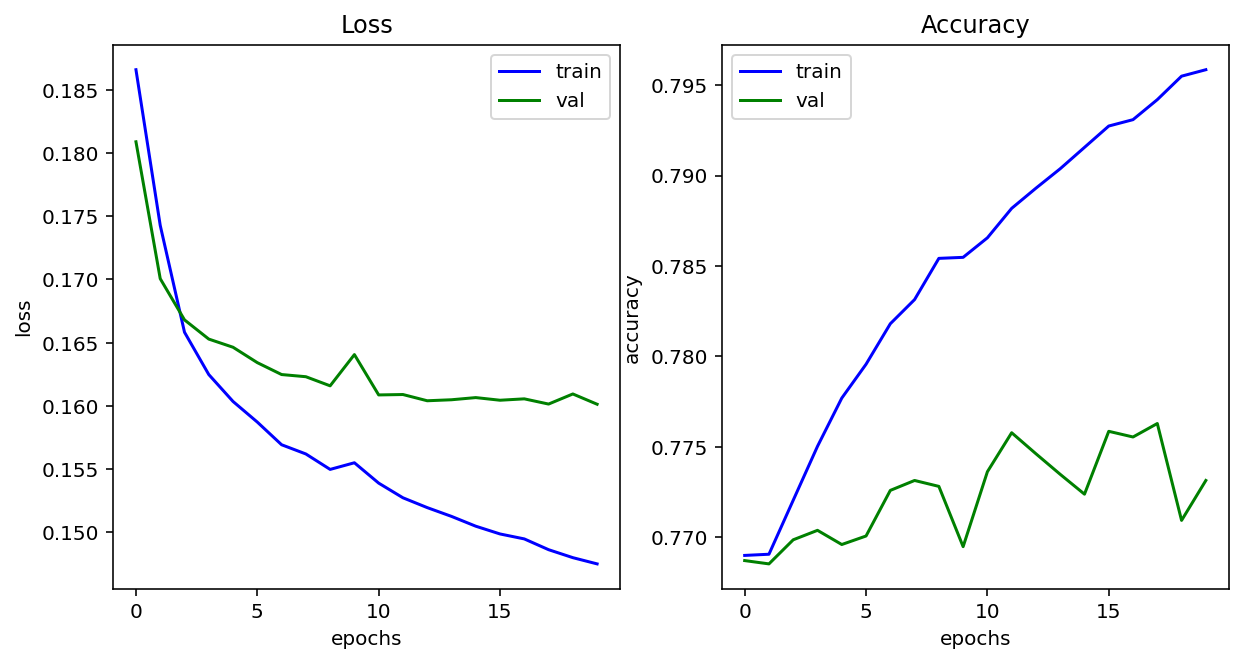

In [ ]:
malstm.save(os.path.join(base_path, 'model_result', 'MaLSTM.h5'))
show_history(malstm_history)

#### 2. 새로 만든 모델 (LSTM + Fully connected layer)

In [ ]:
def create_LSTM_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # lstm
  lstm_layer = LSTM(50,
                    kernel_initializer=initializers.glorot_uniform(seed=main_seed))
  left_output = lstm_layer(left_encoded)
  right_output = lstm_layer(right_encoded)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
lstmfc = create_LSTM_FC(max_len)

lstmfc.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

lstmfc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 514, 300)     211276500   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           70200       embedding_1[0][0]          

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks('LSTM_FC')

lstmfc_history = lstmfc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 99s 425ms/step - loss: 0.5538 - accuracy: 0.7550 - val_loss: 0.5227 - val_accuracy: 0.7703

Epoch 00001: val_loss improved from inf to 0.52271, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/LSTM_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 96s 425ms/step - loss: 0.5103 - accuracy: 0.7708 - val_loss: 0.5033 - val_accuracy: 0.7713

Epoch 00002: val_loss improved from 0.52271 to 0.50326, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/LSTM_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 89s 398ms/step - loss: 0.5030 - accuracy: 0.7722 - val_loss: 0.5218 - val_accuracy: 0.7736

Epoch 00003: val_loss did not improve from 0.50326
Epoch 4/20
225/225 [==============================] - 92s 409ms/step - loss: 0.5001 - accuracy: 0.7743 - val_loss: 0.4800 - val_accuracy: 0.7810

Epoch 00004: val_loss improved from 0.50326 to 0.48003, saving model to drive/M

In [ ]:
# validation dataset accuracy, f1_score

%%time
lstmfc.load_weights(file_path)
y_pred = lstmfc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7843915689398491
val f1_score: 0.28010813639138393
CPU times: user 1min 4s, sys: 5 s, total: 1min 9s
Wall time: 59.6 s


새로 만든 모델의 validation dataset에 대한 정확도는 약 0.7844, f1 score는 약 0.2801로 기준 모델보다 높기 때문에 학습이 잘 된 의미있는 모델이라고 할 수 있다. 또한 MaLSTM 모델보다도 accuracy와 f1 score가 높으므로 가설이 맞음도 확인할 수 있다.

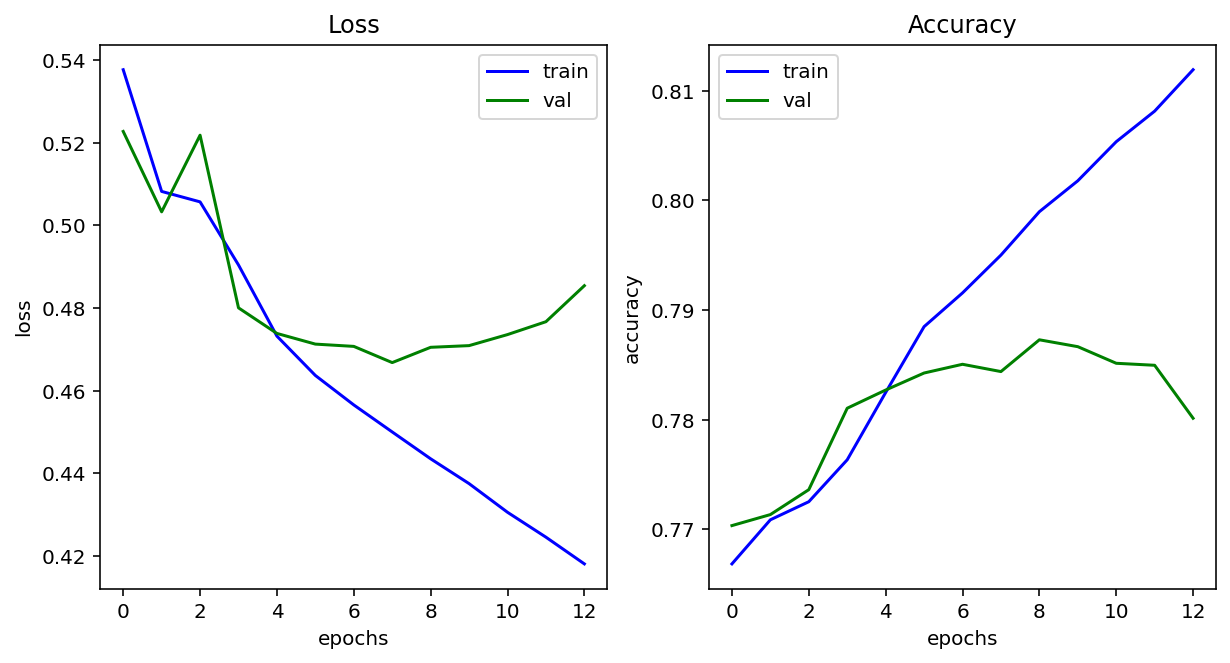

In [ ]:
lstmfc.save(os.path.join(base_path, 'model_result', 'LSTM_FC.h5'))
show_history(lstmfc_history)

### 3) 모델 발전시키기

#### 1. LSTM을 다른 RNN 계열 layer로 변경

##### BiLSTM + FC layer

In [ ]:
def create_BiLSTM_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # Bidirectional LSTM
  lstm_layer = Bidirectional(
      LSTM(50,
           kernel_initializer=initializers.glorot_uniform(seed=main_seed)))
  left_output = lstm_layer(left_encoded)
  right_output = lstm_layer(right_encoded)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
bilstmfc = create_BiLSTM_FC(max_len)

bilstmfc.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

bilstmfc.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 514, 300)     211276500   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100)          140400      embedding_2[0][0]          

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks('BiLSTM_FC')

bilstmfc_history = bilstmfc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 145s 627ms/step - loss: 0.5525 - accuracy: 0.7573 - val_loss: 0.5312 - val_accuracy: 0.7709

Epoch 00001: val_loss improved from inf to 0.53121, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/BiLSTM_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 141s 628ms/step - loss: 0.5248 - accuracy: 0.7698 - val_loss: 0.5207 - val_accuracy: 0.7657

Epoch 00002: val_loss improved from 0.53121 to 0.52066, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/BiLSTM_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 142s 632ms/step - loss: 0.5187 - accuracy: 0.7714 - val_loss: 0.4840 - val_accuracy: 0.7780

Epoch 00003: val_loss improved from 0.52066 to 0.48401, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/BiLSTM_FC_weight.hdf5
Epoch 4/20
225/225 [==============================] - 142s 632ms/step - loss: 0.4843 - accuracy: 0.7762 - val_loss: 0.4796

In [ ]:
# validation dataset accuracy, f1_score

%%time
bilstmfc.load_weights(file_path)
y_pred = bilstmfc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7866899992164442
val f1_score: 0.2972205490061096
CPU times: user 1min 39s, sys: 7.81 s, total: 1min 47s
Wall time: 1min 37s


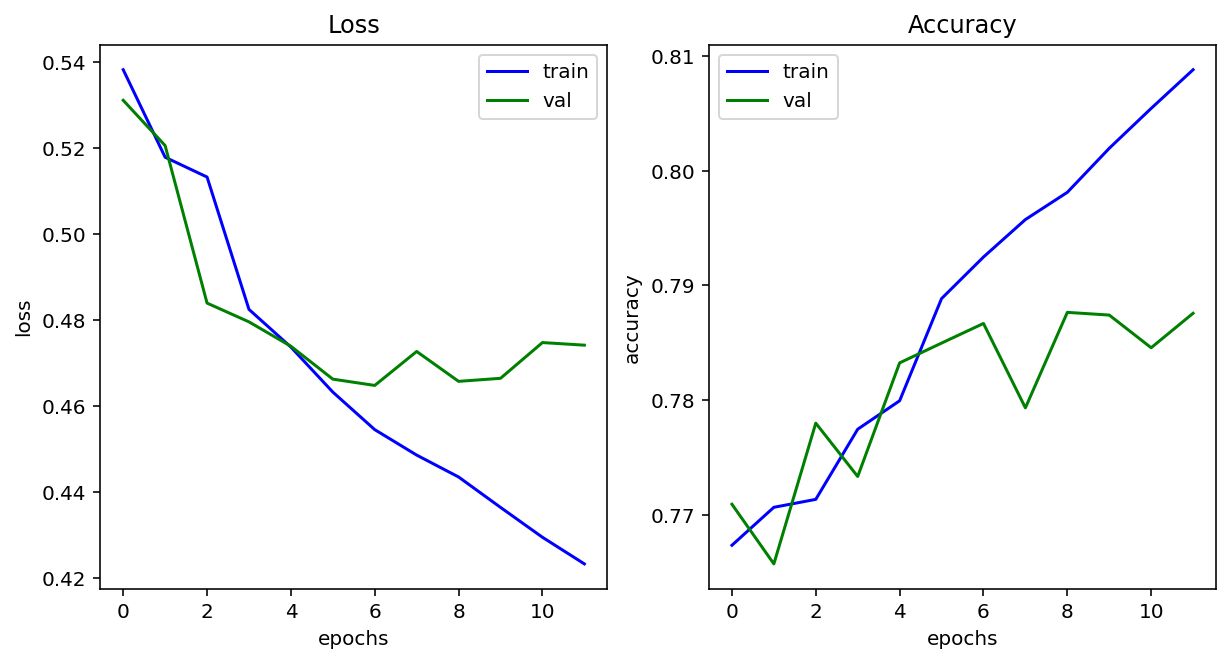

In [ ]:
bilstmfc.save(os.path.join(base_path, 'model_result', 'BiLSTM_FC.h5'))
show_history(bilstmfc_history)

##### GRU + FC layer

In [ ]:
def create_GRU_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # gru
  gru_layer = GRU(50,
                  kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                  recurrent_initializer=initializers.Orthogonal(seed=main_seed))
  left_output = gru_layer(left_encoded)
  right_output = gru_layer(right_encoded)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
grufc = create_GRU_FC(max_len)

grufc.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

grufc.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 514, 300)     211276500   input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 50)           52800       embedding_3[0][0]          

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks('GRU_FC')

gru_history = grufc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 92s 390ms/step - loss: 0.5573 - accuracy: 0.7536 - val_loss: 0.5196 - val_accuracy: 0.7713

Epoch 00001: val_loss improved from inf to 0.51963, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/GRU_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 87s 385ms/step - loss: 0.5134 - accuracy: 0.7711 - val_loss: 0.4822 - val_accuracy: 0.7728

Epoch 00002: val_loss improved from 0.51963 to 0.48215, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/GRU_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 86s 384ms/step - loss: 0.4760 - accuracy: 0.7793 - val_loss: 0.4717 - val_accuracy: 0.7817

Epoch 00003: val_loss improved from 0.48215 to 0.47170, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/GRU_FC_weight.hdf5
Epoch 4/20
225/225 [==============================] - 87s 386ms/step - loss: 0.4632 - accuracy: 0.7863 - val_loss: 0.4662 - val_accura

In [ ]:
# validation dataset accuracy, f1_score

%%time
grufc.load_weights(file_path)
y_pred = grufc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7888839553895578
val f1_score: 0.3152901313002965
CPU times: user 58.6 s, sys: 3.9 s, total: 1min 2s
Wall time: 48.2 s


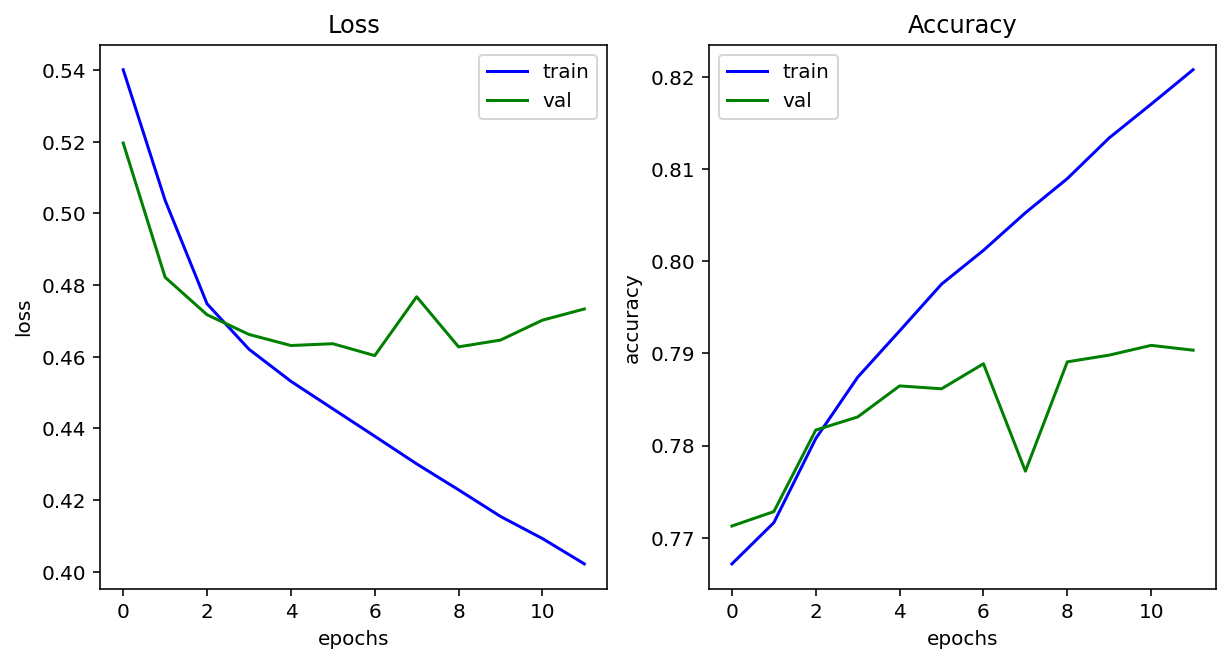

In [ ]:
grufc.save(os.path.join(base_path, 'model_result', 'GRU_FC.h5'))
show_history(gru_history)

##### BiGRU + FC

In [ ]:
def create_BiGRU_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # BiGRU (left_input과 right_input이 동일한 BiGRU layer를 사용함)
  bigru_layer = Bidirectional(
      GRU(50,
          kernel_initializer=initializers.glorot_uniform(seed=main_seed),
          recurrent_initializer=initializers.Orthogonal(seed=main_seed)))
  left_output = bigru_layer(left_encoded)
  right_output = bigru_layer(right_encoded)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
bigrufc = create_BiGRU_FC(max_len)

bigrufc.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

bigrufc.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 514, 300)     211276500   input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 100)          105600      embedding_7[0][0]          

In [ ]:
tf.random.set_seed(42)

early_stop, save_best, file_path = set_callbacks('BiGRU_FC')

bigru_history = bigrufc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 136s 584ms/step - loss: 0.5558 - accuracy: 0.7577 - val_loss: 0.5223 - val_accuracy: 0.7713

Epoch 00001: val_loss improved from inf to 0.52230, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/BiGRU_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 130s 580ms/step - loss: 0.5226 - accuracy: 0.7715 - val_loss: 0.5239 - val_accuracy: 0.7715

Epoch 00002: val_loss did not improve from 0.52230
Epoch 3/20
225/225 [==============================] - 130s 579ms/step - loss: 0.5165 - accuracy: 0.7730 - val_loss: 0.4779 - val_accuracy: 0.7806

Epoch 00003: val_loss improved from 0.52230 to 0.47792, saving model to drive/MyDrive/IMDB_Spoiler_Dataset_edit/model_result/BiGRU_FC_weight.hdf5
Epoch 4/20
225/225 [==============================] - 130s 578ms/step - loss: 0.4708 - accuracy: 0.7841 - val_loss: 0.4678 - val_accuracy: 0.7854

Epoch 00004: val_loss improved from 0.47792 to 0.46777, saving model to d

In [ ]:
# validation dataset accuracy, f1_score

%%time
bigrufc.load_weights(file_path)
y_pred = bigrufc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7909473189333194
val f1_score: 0.34377305894892185
CPU times: user 1min 30s, sys: 4.5 s, total: 1min 34s
Wall time: 1min 21s


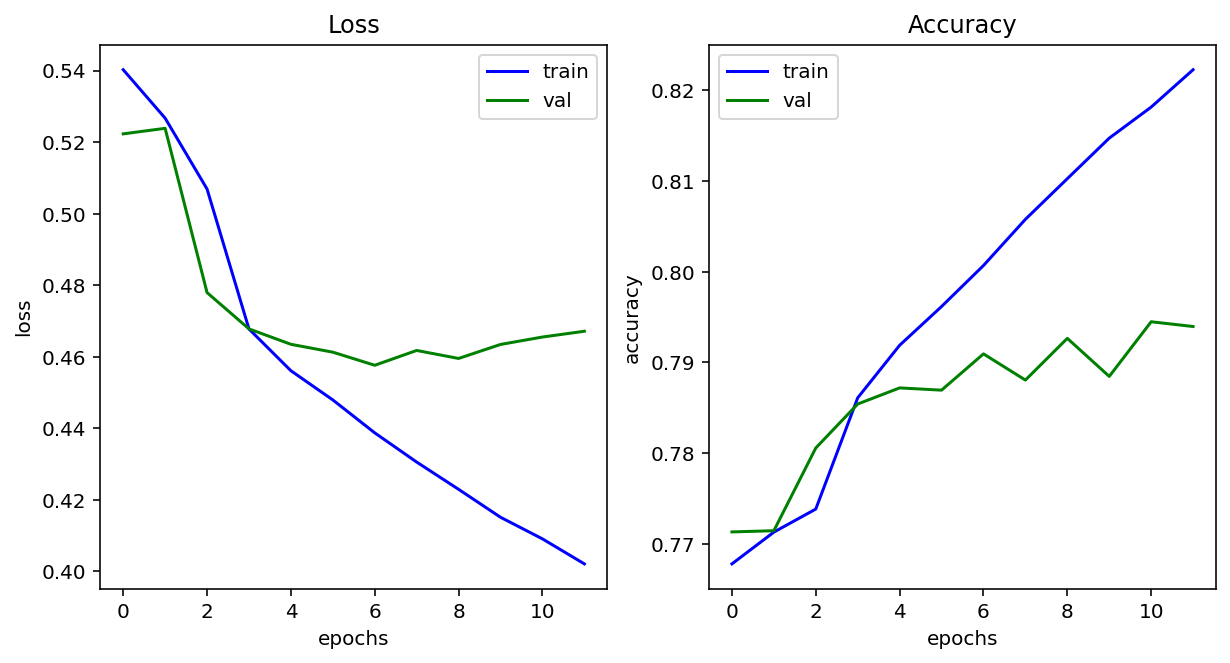

In [ ]:
bigrufc.save(os.path.join(base_path, 'model_result', 'BiGRU_FC.h5'))
show_history(bigru_history)

##### 지금까지 결과 정리

|        | accuracy | f1 score |
|:-------|:--------:|:--------:|
| LSTM   | 0.7844   | 0.2801   |
| GRU    | 0.7889   | 0.3153   |
| BiLSTM | 0.7867   | 0.2972   |
| BiGRU  | 0.7910   | 0.3438   |

- 모든 새로 만든 모델의 accuracy와 f1 score가 기준 모델의 accuracy(약 0.7693), f1 score(0)보다 높았다.

- 대체로 LSTM을 사용했을 때보다 GRU를 사용했을 때가 accuracy와 f1 score가 더 높았다.

#### 2. CNN(Conv1D) 사용

- Kim, Y. (2014). Convolutional Neural Networks for Sentence Classification. *Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)*, 1746–1751.
    https://arxiv.org/abs/1408.5882  

- Pontes, E., & Huet, S., & Linhares, A., Torres-Moreno, J. (2018). Predicting the Semantic Textual Similarity with Siamese CNN and LSTM. *Traitement Automatique des Langues Naturelles (TALN)*, 1, 311–320.
    https://arxiv.org/abs/1810.10641

##### CNN + LSTM + FC

In [ ]:
def create_CNN_LSTM_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN
  cnn1d_layer = Conv1D(300, 3,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # LSTM
  lstm_layer = LSTM(50,
                    kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                    bias_initializer=initializers.Constant(value=2.5),
                    return_sequences=True)
  left_output = lstm_layer(left_output)
  right_output = lstm_layer(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
cnnlstmfc = create_CNN_LSTM_FC(max_len)

# oprimizer = keras.optimizers.Adadelta(lr=0.01)
cnnlstmfc.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnnlstmfc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 514, 300)     211276500   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 514, 300)     270300      embedding_1[0][0]          

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks_ver2('CNN1D_LSTM_FC')

cnnlstmfc_history = cnnlstmfc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 110s 476ms/step - loss: 0.5538 - accuracy: 0.7586 - val_loss: 0.4860 - val_accuracy: 0.7707

Epoch 00001: val_loss improved from inf to 0.48602, saving model to CNN1D_LSTM_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 106s 473ms/step - loss: 0.4846 - accuracy: 0.7745 - val_loss: 0.4724 - val_accuracy: 0.7821

Epoch 00002: val_loss improved from 0.48602 to 0.47236, saving model to CNN1D_LSTM_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 106s 471ms/step - loss: 0.4661 - accuracy: 0.7851 - val_loss: 0.4638 - val_accuracy: 0.7865

Epoch 00003: val_loss improved from 0.47236 to 0.46379, saving model to CNN1D_LSTM_FC_weight.hdf5
Epoch 4/20
225/225 [==============================] - 106s 474ms/step - loss: 0.4579 - accuracy: 0.7894 - val_loss: 0.4617 - val_accuracy: 0.7884

Epoch 00004: val_loss improved from 0.46379 to 0.46168, saving model to CNN1D_LSTM_FC_weight.hdf5
Epoch 5/20
225/225 [====

In [ ]:
# validation dataset accuracy, f1_score

%%time
cnnlstmfc.load_weights(file_path)
y_pred = cnnlstmfc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7932457492099146
val f1_score: 0.40788391053930734
CPU times: user 1min 3s, sys: 2.67 s, total: 1min 6s
Wall time: 51.7 s


In [ ]:
cnnlstmfc.save_weights(os.path.join(base_path, 'model_result', 'CNN1D_LSTM_FC_weight.hdf5'))

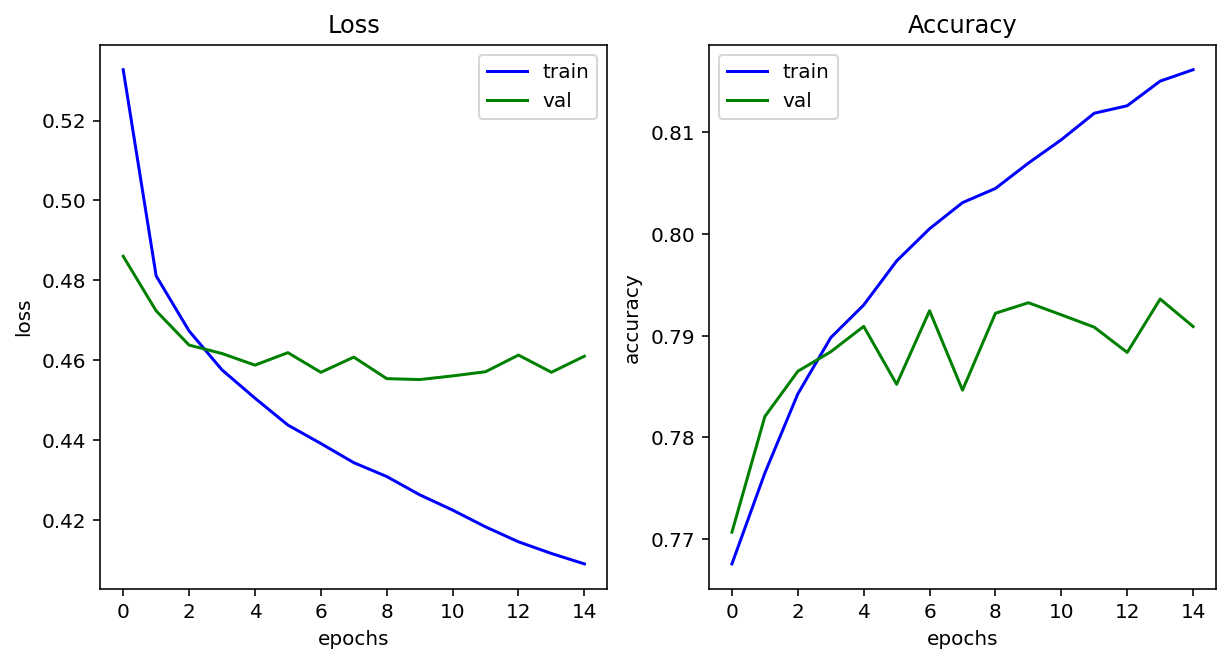

In [ ]:
cnnlstmfc.save(os.path.join(base_path, 'model_result', 'CNN1D_LSTM_FC.h5'))
show_history(cnnlstmfc_history)

##### CNN + GRU + FC


In [ ]:
def create_CNN_GRU_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN
  cnn1d_layer = Conv1D(300, 3,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # GRU
  gru_layer = GRU(50,
                  kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                  recurrent_initializer=initializers.Orthogonal(seed=main_seed),
                  return_sequences=True)
  left_output = gru_layer(left_output)
  right_output = gru_layer(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_uniform(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
cnngrufc = create_CNN_GRU_FC(max_len)

cnngrufc.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnngrufc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 514, 300)     211276500   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 514, 300)     270300      embedding[0][0]              

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks_ver2('CNN1D_GRU_FC')

cnngrufc_history = cnngrufc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 109s 452ms/step - loss: 0.5327 - accuracy: 0.7620 - val_loss: 0.4756 - val_accuracy: 0.7800

Epoch 00001: val_loss improved from inf to 0.47563, saving model to CNN1D_GRU_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 100s 445ms/step - loss: 0.4725 - accuracy: 0.7804 - val_loss: 0.4651 - val_accuracy: 0.7856

Epoch 00002: val_loss improved from 0.47563 to 0.46514, saving model to CNN1D_GRU_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 100s 445ms/step - loss: 0.4577 - accuracy: 0.7891 - val_loss: 0.4624 - val_accuracy: 0.7868

Epoch 00003: val_loss improved from 0.46514 to 0.46235, saving model to CNN1D_GRU_FC_weight.hdf5
Epoch 4/20
225/225 [==============================] - 100s 446ms/step - loss: 0.4491 - accuracy: 0.7929 - val_loss: 0.4594 - val_accuracy: 0.7894

Epoch 00004: val_loss improved from 0.46235 to 0.45936, saving model to CNN1D_GRU_FC_weight.hdf5
Epoch 5/20
225/225 [========

In [ ]:
# validation dataset accuracy, f1_score

%%time
cnngrufc.load_weights(file_path)
y_pred = cnngrufc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.791835348812913
val f1_score: 0.3718969185909055
CPU times: user 1min 4s, sys: 2.31 s, total: 1min 6s
Wall time: 49.2 s


In [ ]:
cnngrufc.save_weights(os.path.join(base_path, 'model_result', 'CNN1D_GRU_FC_weight.hdf5'))

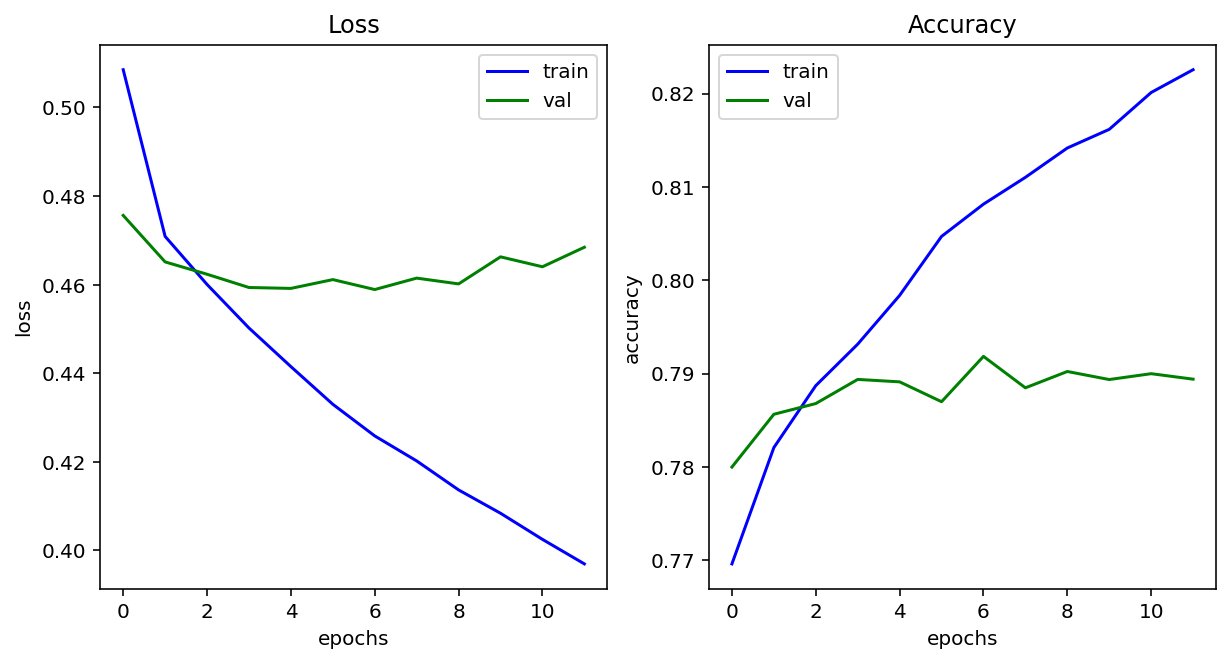

In [ ]:
cnngrufc.save(os.path.join(base_path, 'model_result', 'CNN1D_GRU_FC.h5'))
show_history(cnngrufc_history)

##### CNN + BiLSTM + FC

In [ ]:
def create_CNN_BiLSTM_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN 
  cnn1d_layer = Conv1D(300, 3,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # BiLSTM
  bilstm_layer = Bidirectional(
      LSTM(50,
           kernel_initializer=initializers.glorot_uniform(seed=main_seed),
           bias_initializer=initializers.Constant(value=2.5),
           return_sequences=True))
  left_output = bilstm_layer(left_output)
  right_output = bilstm_layer(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
cnnbilstmfc = create_CNN_BiLSTM_FC(max_len)

cnnbilstmfc.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

cnnbilstmfc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 514, 300)     211276500   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 514, 300)     270300      embedding_1[0][0]          

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks_ver2('CNN1D_BiLSTM_FC')

cnnbilstmfc_history = cnnbilstmfc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 147s 633ms/step - loss: 0.5478 - accuracy: 0.7649 - val_loss: 0.4870 - val_accuracy: 0.7693

Epoch 00001: val_loss improved from inf to 0.48699, saving model to CNN1D_BiLSTM_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 142s 632ms/step - loss: 0.4832 - accuracy: 0.7739 - val_loss: 0.4689 - val_accuracy: 0.7836

Epoch 00002: val_loss improved from 0.48699 to 0.46894, saving model to CNN1D_BiLSTM_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 146s 647ms/step - loss: 0.4642 - accuracy: 0.7861 - val_loss: 0.4640 - val_accuracy: 0.7862

Epoch 00003: val_loss improved from 0.46894 to 0.46400, saving model to CNN1D_BiLSTM_FC_weight.hdf5
Epoch 4/20
225/225 [==============================] - 142s 630ms/step - loss: 0.4560 - accuracy: 0.7893 - val_loss: 0.4631 - val_accuracy: 0.7879

Epoch 00004: val_loss improved from 0.46400 to 0.46309, saving model to CNN1D_BiLSTM_FC_weight.hdf5
Epoch 5/20
225/2

In [ ]:
# validation dataset accuracy, f1_score

%%time
cnnbilstmfc.load_weights(file_path)
y_pred = cnnbilstmfc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7923316008044506
val f1_score: 0.41234294161123425
CPU times: user 1min 42s, sys: 3.89 s, total: 1min 46s
Wall time: 1min 26s


In [ ]:
cnnbilstmfc.save_weights(os.path.join(base_path, 'model_result', 'CNN1D_BiLSTM_FC_weight.hdf5'))

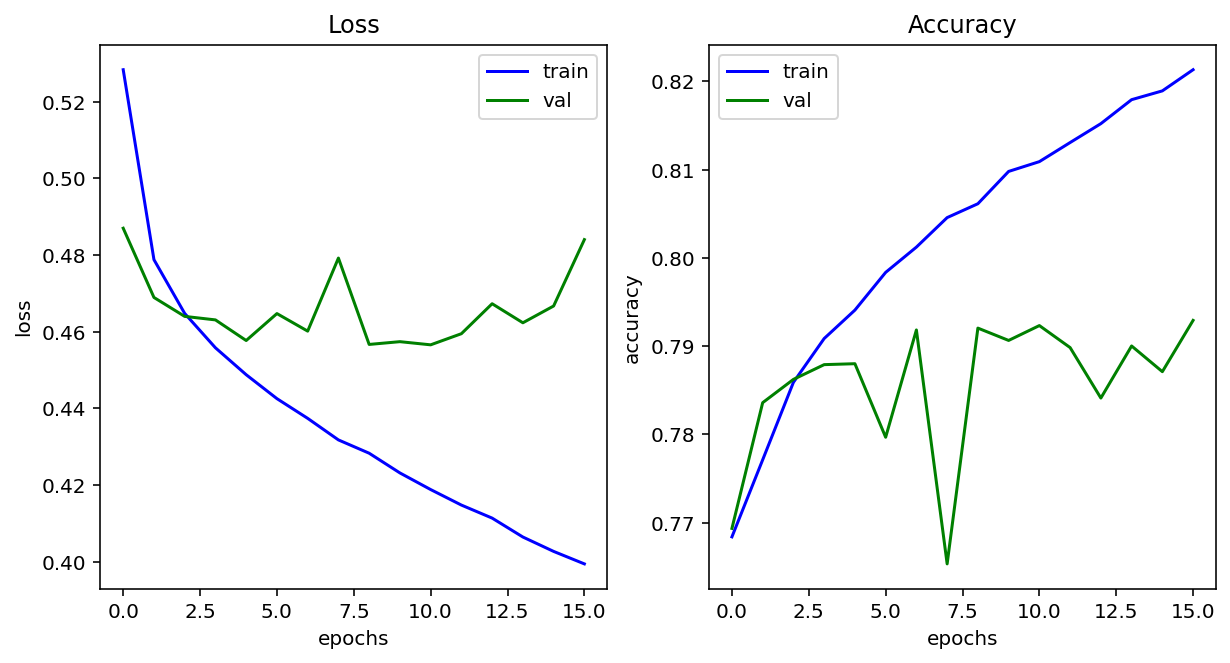

In [ ]:
cnnbilstmfc.save(os.path.join(base_path, 'model_result', 'CNN1D_BiLSTM_FC.h5'))
show_history(cnnbilstmfc_history)

##### 결과 정리

|              | accuracy | f1 score |
|:-------------|:--------:|:--------:|
| CNN + LSTM   | 0.7932   | 0.4079   |
| CNN + GRU    | 0.7918   | 0.3719   |
| CNN + BiLSTM | 0.7923   | 0.4123   |

- RNN layer의 종류와 상관없이 CNN을 사용했을 때의 accuracy와 f1 score가 사용하지 않았을 때보다 높았다.
- GRU를 사용했을 때보다 LSTM을 사용했을 때가 accuracy와 f1 score 더 높았다.

#### 3. CNN, LSTM, BiLSTM 모두 사용하기

- ['클린봇 2.0: 문맥을 이해하는 악성 댓글(단문) 탐지 AI'](https://d2.naver.com/helloworld/7753273)를 참고하여 변형함

##### CNN + BiLSTM + LSTM + FC

In [ ]:
def create_CNN_BiLSTM_LSTM_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN (left_input과 right_input이 동일한 CNN layer를 사용함)
  cnn1d_layer = Conv1D(300, 3,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # BiLSTM
  bilstm_layer = Bidirectional(
      LSTM(50,
           kernel_initializer=initializers.glorot_uniform(seed=main_seed),
           bias_initializer=initializers.Constant(value=2.5),
           return_sequences=True))
  left_output = bilstm_layer(left_output)
  right_output = bilstm_layer(right_output)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # LSTM
  lstm_layer = LSTM(50,
                    kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                    bias_initializer=initializers.Constant(value=2.5),
                    return_sequences=True)
  left_output = lstm_layer(left_output)
  right_output = lstm_layer(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
cnnbilstmlstmfc = create_CNN_BiLSTM_LSTM_FC(max_len)

cnnbilstmlstmfc.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

cnnbilstmlstmfc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 514, 300)     211276500   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 514, 300)     270300      embedding[0][0]              

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks_ver2('CNN1D_BiLSTM_LSTM_FC')

cnnbilstmlstmfc_history = cnnbilstmlstmfc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 190s 786ms/step - loss: 0.5471 - accuracy: 0.7667 - val_loss: 0.5076 - val_accuracy: 0.7693

Epoch 00001: val_loss improved from inf to 0.50760, saving model to CNN1D_BiLSTM_LSTM_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 175s 778ms/step - loss: 0.4917 - accuracy: 0.7704 - val_loss: 0.4780 - val_accuracy: 0.7782

Epoch 00002: val_loss improved from 0.50760 to 0.47798, saving model to CNN1D_BiLSTM_LSTM_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 175s 777ms/step - loss: 0.4778 - accuracy: 0.7801 - val_loss: 0.4796 - val_accuracy: 0.7781

Epoch 00003: val_loss did not improve from 0.47798
Epoch 4/20
225/225 [==============================] - 172s 763ms/step - loss: 0.4730 - accuracy: 0.7836 - val_loss: 0.4692 - val_accuracy: 0.7872

Epoch 00004: val_loss improved from 0.47798 to 0.46916, saving model to CNN1D_BiLSTM_LSTM_FC_weight.hdf5
Epoch 5/20
225/225 [==============================

In [ ]:
# validation dataset accuracy, f1_score

%%time
cnnbilstmlstmfc.load_weights(file_path)
y_pred = cnnbilstmlstmfc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7955180609606394
val f1_score: 0.3689343865871352
CPU times: user 2min 26s, sys: 4.65 s, total: 2min 31s
Wall time: 2min 3s


In [ ]:
cnnbilstmlstmfc.save_weights(os.path.join(base_path, 'model_result', 'CNN1D_BiLSTM_LSTM_FC_weight.hdf5'))

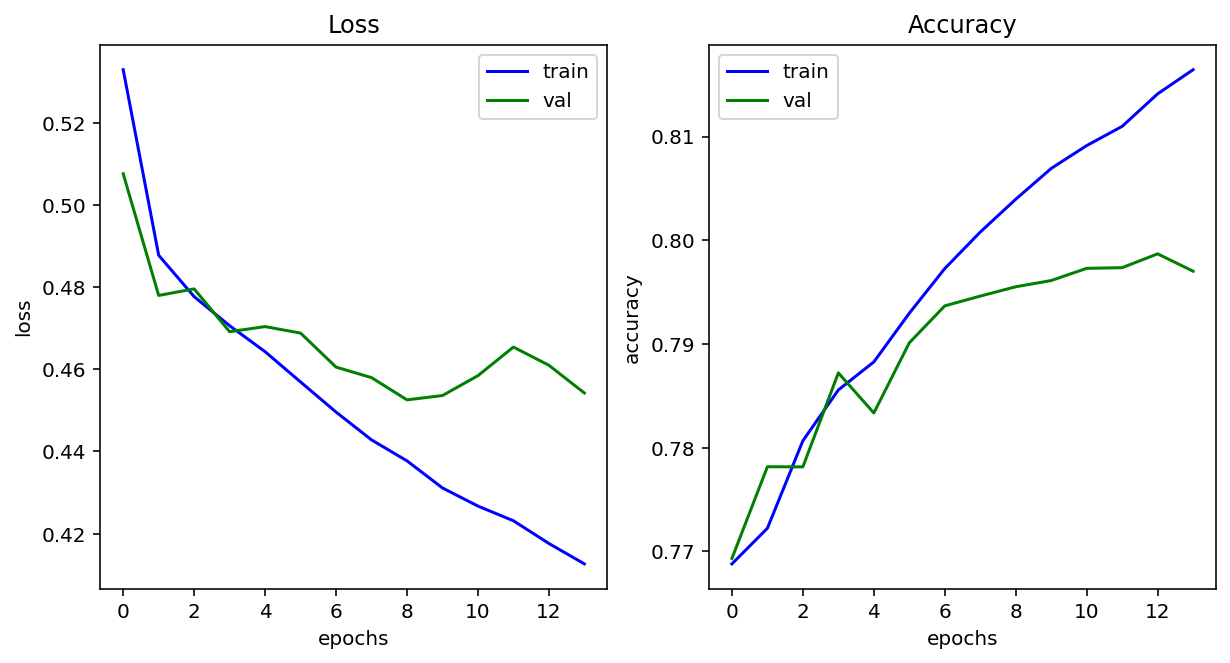

In [ ]:
cnnbilstmlstmfc.save(os.path.join(base_path, 'model_result', 'CNN1D_BiLSTM_LSTM_FC.h5'))
show_history(cnnbilstmlstmfc_history)

##### CNN + LSTM + LSTM + FC

In [ ]:
def create_CNN_LSTM_LSTM_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN (left_input과 right_input이 동일한 CNN layer를 사용함)
  cnn1d_layer = Conv1D(300, 3,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # LSTM1
  lstm_layer1 = LSTM(50,
                     kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                     bias_initializer=initializers.Constant(value=2.5),
                     return_sequences=True)
  left_output = lstm_layer1(left_output)
  right_output = lstm_layer1(right_output)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # LSTM2
  lstm_layer2 = LSTM(50,
                     kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                     bias_initializer=initializers.Constant(value=2.5),
                     return_sequences=True)
  left_output = lstm_layer2(left_output)
  right_output = lstm_layer2(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
cnnlstmlstmfc = create_CNN_LSTM_LSTM_FC(max_len)

cnnlstmlstmfc.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

cnnlstmlstmfc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 514, 300)     211276500   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 514, 300)     270300      embedding_1[0][0]          

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks_ver2('CNN1D_LSTM_LSTM_FC')

cnnlstmlstmfc_history = cnnlstmlstmfc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 138s 592ms/step - loss: 0.5489 - accuracy: 0.7667 - val_loss: 0.4906 - val_accuracy: 0.7693

Epoch 00001: val_loss improved from inf to 0.49056, saving model to CNN1D_LSTM_LSTM_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 133s 590ms/step - loss: 0.4917 - accuracy: 0.7704 - val_loss: 0.4757 - val_accuracy: 0.7821

Epoch 00002: val_loss improved from 0.49056 to 0.47572, saving model to CNN1D_LSTM_LSTM_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 133s 590ms/step - loss: 0.4749 - accuracy: 0.7815 - val_loss: 0.4688 - val_accuracy: 0.7839

Epoch 00003: val_loss improved from 0.47572 to 0.46876, saving model to CNN1D_LSTM_LSTM_FC_weight.hdf5
Epoch 4/20
225/225 [==============================] - 133s 590ms/step - loss: 0.4676 - accuracy: 0.7848 - val_loss: 0.4660 - val_accuracy: 0.7882

Epoch 00004: val_loss improved from 0.46876 to 0.46605, saving model to CNN1D_LSTM_LSTM_FC_weight.hdf5
Epoc

In [ ]:
# validation dataset accuracy, f1_score

%%time
cnnlstmlstmfc.load_weights(file_path)
y_pred = cnnlstmlstmfc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7968892835688354
val f1_score: 0.35295585971627075
CPU times: user 1min 50s, sys: 3.43 s, total: 1min 53s
Wall time: 1min 29s


In [ ]:
cnnlstmlstmfc.save_weights(os.path.join(base_path, 'model_result', 'CNN1D_LSTM_LSTM_FC_weight.hdf5'))

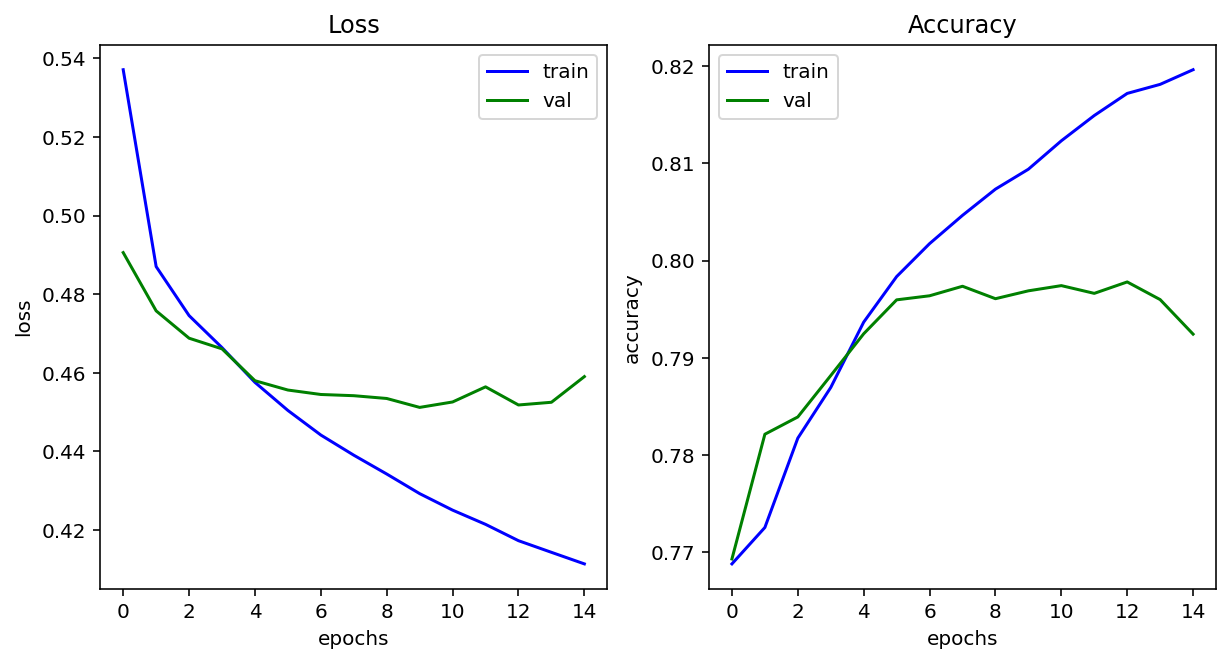

In [ ]:
cnnlstmlstmfc.save(os.path.join(base_path, 'model_result', 'CNN1D_LSTM_LSTM_FC.h5'))
show_history(cnnlstmlstmfc_history)

##### CNN + LSTM + BiLSTM + FC

In [ ]:
def create_CNN_LSTM_BiLSTM_FC(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN (left_input과 right_input이 동일한 CNN layer를 사용함)
  cnn1d_layer = Conv1D(300, 3,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # LSTM
  lstm_layer = LSTM(50,
                    kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                    bias_initializer=initializers.Constant(value=2.5),
                    return_sequences=True)
  left_output = lstm_layer(left_output)
  right_output = lstm_layer(right_output)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # BiLSTM
  bilstm_layer = Bidirectional(
      LSTM(50,
           kernel_initializer=initializers.glorot_uniform(seed=main_seed),
           bias_initializer=initializers.Constant(value=2.5),
           return_sequences=True))
  left_output = bilstm_layer(left_output)
  right_output = bilstm_layer(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
cnnlstmbilstmfc = create_CNN_LSTM_BiLSTM_FC(max_len)

cnnlstmbilstmfc.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

cnnlstmbilstmfc.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 514, 300)     211276500   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 514, 300)     270300      embedding_2[0][0]          

In [ ]:
tf.random.set_seed(main_seed)

early_stop, save_best, file_path = set_callbacks_ver2('CNN1D_LSTM_BiLSTM_FC')

cnnlstmbilstmfc_history = cnnlstmbilstmfc.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1024,
    epochs=20,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/20
225/225 [==============================] - 169s 721ms/step - loss: 0.5541 - accuracy: 0.7648 - val_loss: 0.4898 - val_accuracy: 0.7693

Epoch 00001: val_loss improved from inf to 0.48976, saving model to CNN1D_LSTM_BiLSTM_FC_weight.hdf5
Epoch 2/20
225/225 [==============================] - 160s 713ms/step - loss: 0.4921 - accuracy: 0.7708 - val_loss: 0.4875 - val_accuracy: 0.7758

Epoch 00002: val_loss improved from 0.48976 to 0.48752, saving model to CNN1D_LSTM_BiLSTM_FC_weight.hdf5
Epoch 3/20
225/225 [==============================] - 160s 713ms/step - loss: 0.4783 - accuracy: 0.7802 - val_loss: 0.4736 - val_accuracy: 0.7841

Epoch 00003: val_loss improved from 0.48752 to 0.47358, saving model to CNN1D_LSTM_BiLSTM_FC_weight.hdf5
Epoch 4/20
225/225 [==============================] - 160s 713ms/step - loss: 0.4726 - accuracy: 0.7815 - val_loss: 0.4691 - val_accuracy: 0.7847

Epoch 00004: val_loss improved from 0.47358 to 0.46909, saving model to CNN1D_LSTM_BiLSTM_FC_weight.h

In [ ]:
# validation dataset accuracy, f1_score

%%time
cnnlstmbilstmfc.load_weights(file_path)
y_pred = cnnlstmbilstmfc.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.796732572413613
val f1_score: 0.39225332864784657
CPU times: user 2min 29s, sys: 4.78 s, total: 2min 34s
Wall time: 2min 5s


In [ ]:
cnnlstmbilstmfc.save_weights(os.path.join(base_path, 'model_result', 'CNN1D_LSTM_BiLSTM_FC_weight.hdf5'))

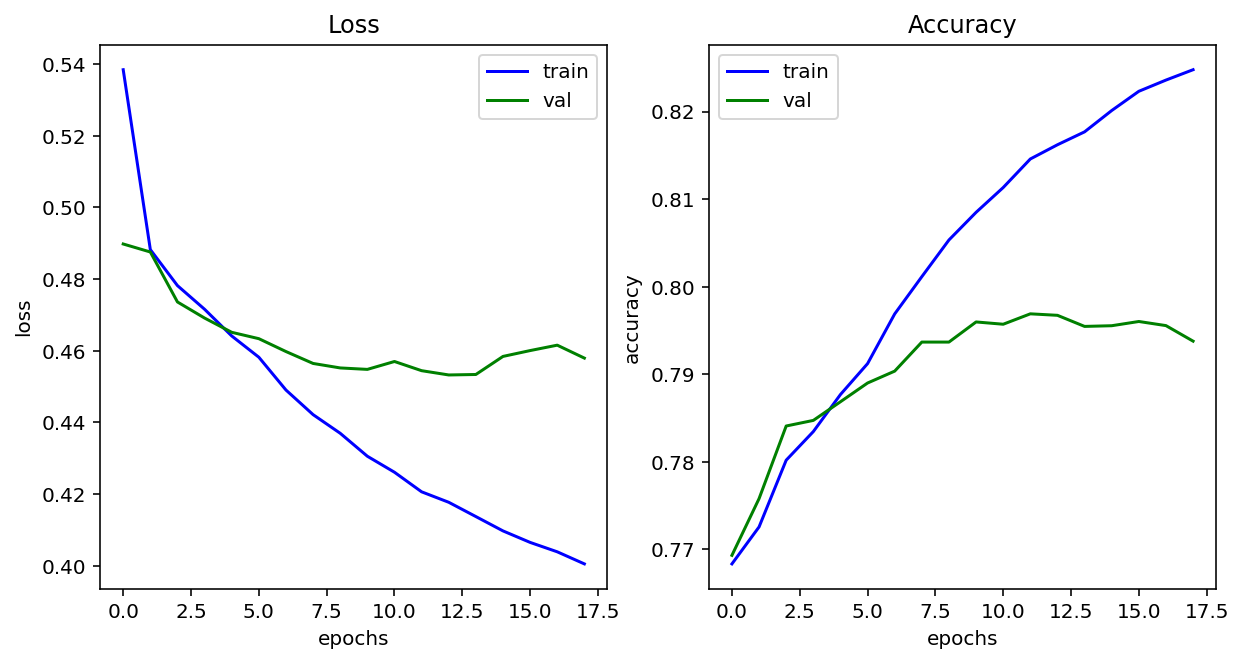

In [ ]:
cnnlstmbilstmfc.save(os.path.join(base_path, 'model_result', 'CNN1D_LSTM_BiLSTM_FC.h5'))
show_history(cnnlstmbilstmfc_history)

##### 결과 정리

|                      | accuracy | f1 score |
|:---------------------|:--------:|:--------:|
| CNN + BiLSTM + LSTM  | 0.7955   | 0.3689   |
| CNN + LSTM + LSTM    | 0.7969   | 0.3530   |
| CNN + LSTM + BiLSTM  | 0.7967   | 0.3926   |

- RNN 계열 layer를 하나만 사용했을 때보다 accuracy가 올라갔다. 다만, f1 score는 떨어졌다.

- 가장 성능이 좋은 모델은 LSTM layer를 2개 사용하였을 때이다.

### 4) CV를 사용해서 하이퍼 파라미터 튜닝

가장 accuracy가 높았던 CNN + LSTM + LSTM + FC에 대해서 진행함

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
batch_size = 1024
epochs = 8

In [ ]:
def create_model_with_cv(max_length,
                         filter_size=3,
                         lstm1_node=50,
                         lstm2_node=50,
                         dropout_rate1=0.2,
                         dropout_rate2=0.2,
                         dense1_node=128,
                         dense2_node=64):
  
  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN 
  cnn1d_layer = Conv1D(300, filter_size,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(dropout_rate1, seed=main_seed)(left_output)
  right_output = Dropout(dropout_rate1, seed=main_seed)(right_output)

  # LSTM1
  lstm_layer1 = LSTM(lstm1_node,
                     kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                     bias_initializer=initializers.Constant(value=2.5),
                     return_sequences=True)
  left_output = lstm_layer1(left_output)
  right_output = lstm_layer1(right_output)

  left_output = Dropout(dropout_rate1, seed=main_seed)(left_output)
  right_output = Dropout(dropout_rate1, seed=main_seed)(right_output)

  # LSTM2
  lstm_layer2 = LSTM(lstm2_node,
                     kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                     bias_initializer=initializers.Constant(value=2.5),
                     return_sequences=True)
  left_output = lstm_layer2(left_output)
  right_output = lstm_layer2(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(dense1_node, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(dropout_rate2, seed=main_seed)(x)
  x = Dense(dense2_node, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(dropout_rate2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

#### 1) optimizer 학습률

In [ ]:
# seed 고정
np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)

# hyper parameter
learning_rate = np.logspace(-4, 0, 5)

kf = StratifiedKFold(len(learning_rate), True, main_seed)
score_list = []
history_list = []

for param, idx in zip(learning_rate, kf.split(X_train['summary'], y_train)):
  print('learning_rate:', param)
  X_train_summary_cv, X_val_summary_cv = X_train['summary'][idx[0]], X_train['summary'][idx[1]]
  X_train_review_cv, X_val_review_cv = X_train['review'][idx[0]], X_train['review'][idx[1]]
  y_train_cv, y_val_cv = y_train[idx[0]], y_train[idx[1]]

  # 모델 생성 및 학습
  model = create_model_with_cv(max_length=max_len)
  
  optimizer = keras.optimizers.Adam(lr=param)
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  cv_history = model.fit(
      [X_train_summary_cv, X_train_review_cv],
      y_train_cv,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=([X_val_summary_cv, X_val_review_cv], y_val_cv));

  score = model.evaluate([X_val_summary_cv, X_val_review_cv], y_val_cv, verbose=2)
  score_list.append(score)
  history_list.append((param, cv_history))

learning_rate: 0.0001
Epoch 1/8
180/180 [==============================] - 115s 586ms/step - loss: 0.5683 - accuracy: 0.7568 - val_loss: 0.5437 - val_accuracy: 0.7693
Epoch 2/8
180/180 [==============================] - 104s 577ms/step - loss: 0.5459 - accuracy: 0.7696 - val_loss: 0.5534 - val_accuracy: 0.7693
Epoch 3/8
180/180 [==============================] - 104s 576ms/step - loss: 0.5461 - accuracy: 0.7681 - val_loss: 0.5430 - val_accuracy: 0.7693
Epoch 4/8
180/180 [==============================] - 103s 575ms/step - loss: 0.5347 - accuracy: 0.7697 - val_loss: 0.5004 - val_accuracy: 0.7693
Epoch 5/8
180/180 [==============================] - 103s 575ms/step - loss: 0.4992 - accuracy: 0.7675 - val_loss: 0.4881 - val_accuracy: 0.7729
Epoch 6/8
180/180 [==============================] - 104s 576ms/step - loss: 0.4856 - accuracy: 0.7723 - val_loss: 0.4834 - val_accuracy: 0.7748
Epoch 7/8
180/180 [==============================] - 103s 571ms/step - loss: 0.4851 - accuracy: 0.7723 - val

In [ ]:
score_array = np.array(score_list)
result_df = pd.DataFrame({
    'learning_rate': learning_rate,
    'val_loss': score_array[:,0],
    'val_accuracy': score_array[:,1]
})

# val_accuracy가 높은 순으로 learning_rate 출력
rs = result_df.sort_values(by=['val_accuracy'], ascending=False)
learning_rate_confirm = rs.iloc[0]['learning_rate']

print(learning_rate_confirm)
rs

0.001


,learning_rate,val_loss,val_accuracy
1,0.0010,0.453986,0.796578
2,0.0100,0.465837,0.788917
0,0.0001,0.479446,0.778165
3,0.1000,0.540147,0.769306
4,1.0000,0.540213,0.769306


#### 2) CNN filter_size

In [ ]:
# seed 고정
np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)

# hyper parameter
filter_size = (2, 3, 5, 7)

kf = StratifiedKFold(len(filter_size), True, main_seed)
score_list = []
history_list = []

for param, idx in zip(filter_size, kf.split(X_train['summary'], y_train)):
  print('filter_size:', param)
  X_train_summary_cv, X_val_summary_cv = X_train['summary'][idx[0]], X_train['summary'][idx[1]]
  X_train_review_cv, X_val_review_cv = X_train['review'][idx[0]], X_train['review'][idx[1]]
  y_train_cv, y_val_cv = y_train[idx[0]], y_train[idx[1]]

  # 모델 생성 및 학습  
  model = create_model_with_cv(max_length=max_len,
                               filter_size=param)
  
  optimizer = keras.optimizers.Adam(lr=learning_rate_confirm)
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  cv_history = model.fit(
      [X_train_summary_cv, X_train_review_cv],
      y_train_cv,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=([X_val_summary_cv, X_val_review_cv], y_val_cv));

  score = model.evaluate([X_val_summary_cv, X_val_review_cv], y_val_cv, verbose=2)
  score_list.append(score)
  history_list.append((param, cv_history))

filter_size: 2
Epoch 1/8
169/169 [==============================] - 103s 584ms/step - loss: 0.5525 - accuracy: 0.7661 - val_loss: 0.5403 - val_accuracy: 0.7693
Epoch 2/8
169/169 [==============================] - 98s 581ms/step - loss: 0.5402 - accuracy: 0.7699 - val_loss: 0.5021 - val_accuracy: 0.7693
Epoch 3/8
169/169 [==============================] - 105s 620ms/step - loss: 0.4937 - accuracy: 0.7681 - val_loss: 0.4813 - val_accuracy: 0.7731
Epoch 4/8
169/169 [==============================] - 100s 594ms/step - loss: 0.4786 - accuracy: 0.7772 - val_loss: 0.4742 - val_accuracy: 0.7826
Epoch 5/8
169/169 [==============================] - 98s 582ms/step - loss: 0.4722 - accuracy: 0.7818 - val_loss: 0.4741 - val_accuracy: 0.7825
Epoch 6/8
169/169 [==============================] - 100s 595ms/step - loss: 0.4682 - accuracy: 0.7832 - val_loss: 0.4813 - val_accuracy: 0.7846
Epoch 7/8
169/169 [==============================] - 97s 574ms/step - loss: 0.4592 - accuracy: 0.7900 - val_loss: 0.4

In [ ]:
score_array = np.array(score_list)
result_df = pd.DataFrame({
    'filter_size': filter_size,
    'val_loss': score_array[:,0],
    'val_accuracy': score_array[:,1]
})

# val_accuracy가 높은 순으로 filter_size 출력
rs = result_df.sort_values(by=['val_accuracy'], ascending=False)
filter_size_confirm = rs.iloc[0]['filter_size']

print(filter_size_confirm)
rs

2.0


,filter_size,val_loss,val_accuracy
0,2,0.460332,0.792965
1,3,0.457398,0.792600
2,5,0.464280,0.792582
3,7,0.471295,0.781682


In [ ]:
filter_size_confirm = int(filter_size_confirm)
filter_size_confirm

2

#### 3) LSTM 노드 수

In [ ]:
# seed 고정
np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)

# hyper parameter
lstm_node = [(50, 50), (50, 100), (100, 50), (100, 100)]

kf = StratifiedKFold(len(lstm_node), True, main_seed)
score_list = []
history_list = []

for param, idx in zip(lstm_node, kf.split(X_train['summary'], y_train)):
  print('lstm node1:', param[0], 'lstm node 2:', param[1])
  X_train_summary_cv, X_val_summary_cv = X_train['summary'][idx[0]], X_train['summary'][idx[1]]
  X_train_review_cv, X_val_review_cv = X_train['review'][idx[0]], X_train['review'][idx[1]]
  y_train_cv, y_val_cv = y_train[idx[0]], y_train[idx[1]]

  # 모델 생성 및 학습  
  model = create_model_with_cv(max_length=max_len,
                               filter_size=filter_size_confirm,
                               lstm1_node=param[0],
                               lstm2_node=param[1])
  
  optimizer = keras.optimizers.Adam(lr=learning_rate_confirm)
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  cv_history = model.fit(
      [X_train_summary_cv, X_train_review_cv],
      y_train_cv,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=([X_val_summary_cv, X_val_review_cv], y_val_cv));

  score = model.evaluate([X_val_summary_cv, X_val_review_cv], y_val_cv, verbose=2)
  score_list.append(score)
  history_list.append((param, cv_history))

lstm node1: 50 lstm node 2: 50
Epoch 1/8
169/169 [==============================] - 104s 587ms/step - loss: 0.5524 - accuracy: 0.7661 - val_loss: 0.5418 - val_accuracy: 0.7693
Epoch 2/8
169/169 [==============================] - 98s 583ms/step - loss: 0.5407 - accuracy: 0.7699 - val_loss: 0.5119 - val_accuracy: 0.7693
Epoch 3/8
169/169 [==============================] - 99s 585ms/step - loss: 0.4978 - accuracy: 0.7680 - val_loss: 0.4873 - val_accuracy: 0.7693
Epoch 4/8
169/169 [==============================] - 99s 584ms/step - loss: 0.4811 - accuracy: 0.7735 - val_loss: 0.4747 - val_accuracy: 0.7812
Epoch 5/8
169/169 [==============================] - 99s 587ms/step - loss: 0.4743 - accuracy: 0.7807 - val_loss: 0.4784 - val_accuracy: 0.7822
Epoch 6/8
169/169 [==============================] - 98s 582ms/step - loss: 0.4687 - accuracy: 0.7839 - val_loss: 0.4735 - val_accuracy: 0.7831
Epoch 7/8
169/169 [==============================] - 99s 585ms/step - loss: 0.4622 - accuracy: 0.7870 - 

In [ ]:
score_array = np.array(score_list)
result_df = pd.DataFrame({
    'lstm_node_1_2': lstm_node,
    'val_loss': score_array[:,0],
    'val_accuracy': score_array[:,1]
})

# val_accuracy가 높은 순으로 노드 수 출력 (첫번째 LSTM layer, 두번째 LSTM layer)
rs = result_df.sort_values(by=['val_accuracy'], ascending=False)
lstm_node_confirm = rs.iloc[0]['lstm_node_1_2']

print(lstm_node_confirm)
rs

(50, 100)


,lstm_node_1_2,val_loss,val_accuracy
1,"(50, 100)",0.454790,0.797057
2,"(100, 50)",0.466665,0.789570
3,"(100, 100)",0.463529,0.785234
0,"(50, 50)",0.465663,0.784068


#### 4) dropout 비율

In [ ]:
# seed 고정
np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)

# hyper parameter
dropout_rate = [(0.2, 0.2), (0.2, 0.5), (0.5, 0.2), (0.5, 0.5)]

kf = StratifiedKFold(len(dropout_rate), True, main_seed)
score_list = []
history_list = []

for param, idx in zip(dropout_rate, kf.split(X_train['summary'], y_train)):
  print('dropout rate 1:', param[0], 'dropout rate 2:', param[1])
  X_train_summary_cv, X_val_summary_cv = X_train['summary'][idx[0]], X_train['summary'][idx[1]]
  X_train_review_cv, X_val_review_cv = X_train['review'][idx[0]], X_train['review'][idx[1]]
  y_train_cv, y_val_cv = y_train[idx[0]], y_train[idx[1]]

  # 모델 생성 및 학습  
  model = create_model_with_cv(max_length=max_len,
                               filter_size=filter_size_confirm,
                               lstm1_node=lstm_node_confirm[0],
                               lstm2_node=lstm_node_confirm[1],
                               dropout_rate1=param[0],
                               dropout_rate2=param[1])
  
  optimizer = keras.optimizers.Adam(lr=learning_rate_confirm)
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  cv_history = model.fit(
      [X_train_summary_cv, X_train_review_cv],
      y_train_cv,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=([X_val_summary_cv, X_val_review_cv], y_val_cv));

  score = model.evaluate([X_val_summary_cv, X_val_review_cv], y_val_cv, verbose=2)
  score_list.append(score)
  history_list.append((param, cv_history))

dropout rate 1: 0.2 dropout rate 2: 0.2
Epoch 1/8
169/169 [==============================] - 114s 646ms/step - loss: 0.5598 - accuracy: 0.7624 - val_loss: 0.5394 - val_accuracy: 0.7693
Epoch 2/8
169/169 [==============================] - 105s 620ms/step - loss: 0.5200 - accuracy: 0.7699 - val_loss: 0.4874 - val_accuracy: 0.7693
Epoch 3/8
169/169 [==============================] - 106s 628ms/step - loss: 0.4859 - accuracy: 0.7695 - val_loss: 0.4867 - val_accuracy: 0.7751
Epoch 4/8
169/169 [==============================] - 107s 631ms/step - loss: 0.4771 - accuracy: 0.7794 - val_loss: 0.4735 - val_accuracy: 0.7812
Epoch 5/8
169/169 [==============================] - 105s 621ms/step - loss: 0.4717 - accuracy: 0.7813 - val_loss: 0.4692 - val_accuracy: 0.7859
Epoch 6/8
169/169 [==============================] - 105s 622ms/step - loss: 0.4658 - accuracy: 0.7861 - val_loss: 0.4708 - val_accuracy: 0.7845
Epoch 7/8
169/169 [==============================] - 105s 621ms/step - loss: 0.4597 - accu

In [ ]:
score_array = np.array(score_list)
result_df = pd.DataFrame({
    'dropout_rate_1_2': dropout_rate,
    'val_loss': score_array[:,0],
    'val_accuracy': score_array[:,1]
})

# val_accuracy가 높은 순으로 dropout 비율 출력 (CNN과 LSTM layer 부분, FC layer 부분)
rs = result_df.sort_values(by=['val_accuracy'], ascending=False)
dropout_rate_confirm = rs.iloc[0]['dropout_rate_1_2']

print(dropout_rate_confirm)
rs

(0.2, 0.2)


,dropout_rate_1_2,val_loss,val_accuracy
0,"(0.2, 0.2)",0.462355,0.792878
3,"(0.5, 0.5)",0.477178,0.787672
1,"(0.2, 0.5)",0.470169,0.785495
2,"(0.5, 0.2)",0.480251,0.782065


#### 5) FC 노드 수 설정

In [ ]:
# seed 고정
np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)

# hyper parameter
dense_node = [(128, 32), (256, 32), (128, 64), (256, 64), (128, 128), (256, 128)]

kf = StratifiedKFold(len(dense_node), True, main_seed)
score_list = []
history_list = []

for param, idx in zip(dense_node, kf.split(X_train['summary'], y_train)):
  print('dense node 1:', param[0], 'dense node 2:', param[1])
  X_train_summary_cv, X_val_summary_cv = X_train['summary'][idx[0]], X_train['summary'][idx[1]]
  X_train_review_cv, X_val_review_cv = X_train['review'][idx[0]], X_train['review'][idx[1]]
  y_train_cv, y_val_cv = y_train[idx[0]], y_train[idx[1]]

  # 모델 생성 및 학습  
  model = create_model_with_cv(max_length=max_len,
                               filter_size=filter_size_confirm,
                               lstm1_node=lstm_node_confirm[0],
                               lstm2_node=lstm_node_confirm[1],
                               dropout_rate1=dropout_rate_confirm[0],
                               dropout_rate2=dropout_rate_confirm[1],
                               dense1_node=param[0],
                               dense2_node=param[1])
  
  optimizer = keras.optimizers.Adam(lr=learning_rate_confirm)
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  cv_history = model.fit(
      [X_train_summary_cv, X_train_review_cv],
      y_train_cv,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=([X_val_summary_cv, X_val_review_cv], y_val_cv));

  score = model.evaluate([X_val_summary_cv, X_val_review_cv], y_val_cv, verbose=2)
  score_list.append(score)
  history_list.append((param, cv_history))

dense node 1: 128 dense node 2: 32
Epoch 1/8
187/187 [==============================] - 112s 576ms/step - loss: 0.5739 - accuracy: 0.7550 - val_loss: 0.5436 - val_accuracy: 0.7693
Epoch 2/8
187/187 [==============================] - 107s 572ms/step - loss: 0.5419 - accuracy: 0.7712 - val_loss: 0.5344 - val_accuracy: 0.7693
Epoch 3/8
187/187 [==============================] - 107s 572ms/step - loss: 0.5140 - accuracy: 0.7687 - val_loss: 0.4790 - val_accuracy: 0.7775
Epoch 4/8
187/187 [==============================] - 107s 571ms/step - loss: 0.4806 - accuracy: 0.7773 - val_loss: 0.4833 - val_accuracy: 0.7810
Epoch 5/8
187/187 [==============================] - 107s 572ms/step - loss: 0.4716 - accuracy: 0.7835 - val_loss: 0.4686 - val_accuracy: 0.7837
Epoch 6/8
187/187 [==============================] - 107s 571ms/step - loss: 0.4654 - accuracy: 0.7859 - val_loss: 0.4658 - val_accuracy: 0.7856
Epoch 7/8
187/187 [==============================] - 107s 573ms/step - loss: 0.4583 - accuracy:

In [ ]:
score_array = np.array(score_list)
result_df = pd.DataFrame({
    'dense_node_1_2': dense_node,
    'val_loss': score_array[:,0],
    'val_accuracy': score_array[:,1]
})

# val_accuracy가 높은 순으로 노드 수 출력 (첫번째 dense layer, 두번째 dense layer)
rs = result_df.sort_values(by=['val_accuracy'], ascending=False)
dense_node_confirm = rs.iloc[0]['dense_node_1_2']

print(dense_node_confirm)
rs

(128, 64)


,dense_node_1_2,val_loss,val_accuracy
2,"(128, 64)",0.452207,0.797425
5,"(256, 128)",0.455577,0.797393
3,"(256, 64)",0.453342,0.796302
1,"(256, 32)",0.453944,0.795179
4,"(128, 128)",0.461456,0.793266
0,"(128, 32)",0.459718,0.788936


#### 6) 배치 사이즈 설정

In [ ]:
filter_size_confirm=2
lstm_node_confirm=(50, 100)
dropout_rate_confirm=(0.2, 0.2)
dense_node_confirm=(128, 64)
learning_rate_confirm=0.001

In [ ]:
# seed 고정
np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)

# hyper parameter
batch_param = (64, 128, 256, 512, 1024)

kf = StratifiedKFold(len(batch_param), True, main_seed)
score_list = []
history_list = []

for param, idx in zip(batch_param, kf.split(X_train['summary'], y_train)):
  print('batch size:', param)
  X_train_summary_cv, X_val_summary_cv = X_train['summary'][idx[0]], X_train['summary'][idx[1]]
  X_train_review_cv, X_val_review_cv = X_train['review'][idx[0]], X_train['review'][idx[1]]
  y_train_cv, y_val_cv = y_train[idx[0]], y_train[idx[1]]

  # 모델 생성 및 학습  
  model = create_model_with_cv(max_length=max_len,
                               filter_size=filter_size_confirm,
                               lstm1_node=lstm_node_confirm[0],
                               lstm2_node=lstm_node_confirm[1],
                               dropout_rate1=dropout_rate_confirm[0],
                               dropout_rate2=dropout_rate_confirm[1],
                               dense1_node=dense_node_confirm[0],
                               dense2_node=dense_node_confirm[1])
  
  optimizer = keras.optimizers.Adam(lr=learning_rate_confirm)
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  cv_history = model.fit(
      [X_train_summary_cv, X_train_review_cv],
      y_train_cv,
      batch_size=param,
      epochs=epochs,
      validation_data=([X_val_summary_cv, X_val_review_cv], y_val_cv));

  score = model.evaluate([X_val_summary_cv, X_val_review_cv], y_val_cv, verbose=2)
  score_list.append(score)
  history_list.append((param, cv_history))

batch size: 64
Epoch 1/8
2872/2872 [==============================] - 383s 131ms/step - loss: 0.5403 - accuracy: 0.7661 - val_loss: 0.4790 - val_accuracy: 0.7715
Epoch 2/8
2872/2872 [==============================] - 376s 131ms/step - loss: 0.4815 - accuracy: 0.7754 - val_loss: 0.4703 - val_accuracy: 0.7827
Epoch 3/8
2872/2872 [==============================] - 375s 131ms/step - loss: 0.4678 - accuracy: 0.7865 - val_loss: 0.4647 - val_accuracy: 0.7917
Epoch 4/8
2872/2872 [==============================] - 377s 131ms/step - loss: 0.4553 - accuracy: 0.7937 - val_loss: 0.4559 - val_accuracy: 0.7939
Epoch 5/8
2872/2872 [==============================] - 373s 130ms/step - loss: 0.4516 - accuracy: 0.7963 - val_loss: 0.4625 - val_accuracy: 0.7917
Epoch 6/8
2872/2872 [==============================] - 373s 130ms/step - loss: 0.4457 - accuracy: 0.7997 - val_loss: 0.4558 - val_accuracy: 0.7956
Epoch 7/8
2872/2872 [==============================] - 370s 129ms/step - loss: 0.4456 - accuracy: 0.799

In [ ]:
score_array = np.array(score_list)
result_df = pd.DataFrame({
    'batch_size': batch_param,
    'val_loss': score_array[:,0],
    'val_accuracy': score_array[:,1]
})

# val_accuracy가 높은 순으로 batch size 출력
rs = result_df.sort_values(by=['val_accuracy'], ascending=False)
batch_size_confirm = rs.iloc[0]['batch_size']

print(batch_size_confirm)
rs

128.0


,batch_size,val_loss,val_accuracy
1,128,0.453952,0.798799
3,512,0.453432,0.796557
2,256,0.459663,0.795751
0,64,0.454211,0.795708
4,1024,0.455264,0.795273


In [ ]:
batch_size_confirm = int(batch_size_confirm)
batch_size_confirm

128

#### 7) early stoping 이용해서 마지막으로 학습하여 최종 모델 생성

In [ ]:
def create_Final_model(max_length):

  # summary와 review 각각 입력 받기
  left_input= Input((max_length, ))
  right_input = Input((max_length, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_length,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # 1D CNN
  cnn1d_layer = Conv1D(300, 2,
                       kernel_initializer=initializers.glorot_normal(seed=main_seed),
                       padding='same')
  left_output = cnn1d_layer(left_encoded)
  right_output = cnn1d_layer(right_encoded)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # LSTM1
  lstm_layer1 = LSTM(50,
                     kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                     bias_initializer=initializers.Constant(value=2.5),
                     return_sequences=True)
  left_output = lstm_layer1(left_output)
  right_output = lstm_layer1(right_output)

  left_output = Dropout(0.2, seed=main_seed)(left_output)
  right_output = Dropout(0.2, seed=main_seed)(right_output)

  # LSTM2
  lstm_layer2 = LSTM(100,
                     kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                     bias_initializer=initializers.Constant(value=2.5),
                     return_sequences=True)
  left_output = lstm_layer2(left_output)
  right_output = lstm_layer2(right_output)

  # GlobalMaxPooling1D
  max_pooling_layer = GlobalMaxPooling1D()
  left_output = max_pooling_layer(left_output)
  right_output = max_pooling_layer(right_output)

  # merge, flatten
  x = concatenate([left_output, right_output])
  x = Flatten()(x)

  # FC
  x = Dense(128, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(64, activation='relu',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)
  x = Dropout(0.2, seed=main_seed)(x)
  x = Dense(1, activation='sigmoid',
            kernel_initializer=initializers.glorot_normal(seed=main_seed))(x)

  model = Model([left_input, right_input], [x])
  return model

In [ ]:
final_model = create_Final_model(max_len)

optimizer = keras.optimizers.Adam(lr=0.001)
final_model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 514)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 514, 300)     211276500   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 514, 300)     180300      embedding[0][0]              

In [ ]:
tf.random.set_seed(main_seed)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=2)
  
file_path = 'Final_Model_weight.hdf5'
save_best = tf.keras.callbacks.ModelCheckpoint(
  filepath=file_path,
  monitor='val_loss',
  verbose=2,
  save_best_only=True,
  save_weights_only=True,
  mode='auto',
  save_freq='epoch',
  option=None)

final_model_history = final_model.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=128,
    epochs=100,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[save_best, early_stop]);

Epoch 1/100
1795/1795 [==============================] - 333s 181ms/step - loss: 0.5429 - accuracy: 0.7684 - val_loss: 0.4904 - val_accuracy: 0.7693

Epoch 00001: val_loss improved from inf to 0.49040, saving model to Final_Model_weight.hdf5
Epoch 2/100
1795/1795 [==============================] - 325s 181ms/step - loss: 0.4851 - accuracy: 0.7724 - val_loss: 0.4734 - val_accuracy: 0.7828

Epoch 00002: val_loss improved from 0.49040 to 0.47336, saving model to Final_Model_weight.hdf5
Epoch 3/100
1795/1795 [==============================] - 325s 181ms/step - loss: 0.4693 - accuracy: 0.7842 - val_loss: 0.4688 - val_accuracy: 0.7845

Epoch 00003: val_loss improved from 0.47336 to 0.46882, saving model to Final_Model_weight.hdf5
Epoch 4/100
1795/1795 [==============================] - 326s 182ms/step - loss: 0.4612 - accuracy: 0.7898 - val_loss: 0.4609 - val_accuracy: 0.7943

Epoch 00004: val_loss improved from 0.46882 to 0.46091, saving model to Final_Model_weight.hdf5
Epoch 5/100
1795/179

In [ ]:
# validation dataset accuracy, f1_score

%%time
final_model.load_weights(file_path)
y_pred = final_model.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.8030140778854441
val f1_score: 0.398180657516757
CPU times: user 1min 51s, sys: 3.6 s, total: 1min 54s
Wall time: 1min 30s


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_class))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     58910
           1       0.67      0.28      0.40     17664

    accuracy                           0.80     76574
   macro avg       0.75      0.62      0.64     76574
weighted avg       0.78      0.80      0.77     76574



In [ ]:
final_model.save_weights(os.path.join(base_path, 'model_result', 'Final_Model_weight.hdf5'))

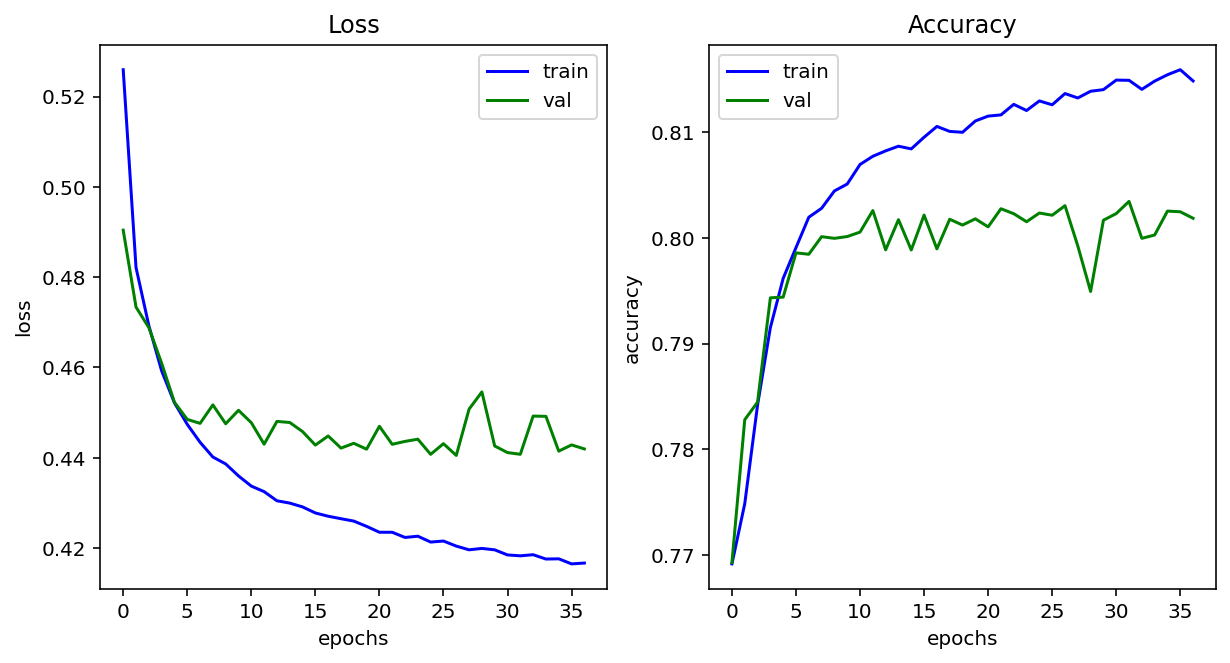

In [ ]:
final_model.save(os.path.join(base_path, 'model_result', 'Final_Model.h5'))
show_history(final_model_history)

### 5) Test dataset에 대한 결과 확인

In [ ]:
y_pred_test = final_model.predict([X_test['summary'], X_test['review']])
y_pred_class_test = np.array([1 if value > 0.5 else 0 for value in y_pred_test])

print('test accuracy:', accuracy_score(y_test, y_pred_class_test))
print('test f1_score:', f1_score(y_test, y_pred_class_test))

test accuracy: 0.8025308851568418
test f1_score: 0.39557101171203585


In [ ]:
test_loss, test_acc = final_model.evaluate([X_test['summary'], X_test['review']], 
                                           y_test,
                                           verbose=2)

2393/2393 - 101s - loss: 0.4423 - accuracy: 0.8025


In [ ]:
print(classification_report(y_test, y_pred_class_test))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     58910
           1       0.67      0.28      0.40     17664

    accuracy                           0.80     76574
   macro avg       0.74      0.62      0.64     76574
weighted avg       0.78      0.80      0.77     76574



최종 모델의 test 데이터셋에 대한 accuracy는 약 0.8025이고, f1 score는 약 0.4000이다. 기준모델에 비하면 성능이 꽤 좋아졌다.